In [71]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from numpy.fft import fft, ifft

In [72]:
# FRAME_SIZE = 1024
# ZP_FACTOR = 2
# FFT_SIZE = FRAME_SIZE * ZP_FACTOR

FRAME_SIZE = 256
ZP_FACTOR = 2
FFT_SIZE = FRAME_SIZE * ZP_FACTOR

In [73]:
################## YOUR CODE HERE ######################
def hammingWindow(N):
    """
    Description: Creates a Hamming window of length N
    """
    window = np.zeros(N)

    for n in range(N):
        window[n] = 0.54 - 0.46 * np.cos((2*np.pi*n)/(N - 1))

    return window

def ece420ProcessFrame(frame, Fs):
    # print("Len frame: {}, FRAME_SIZE: {}".format(len(frame), FRAME_SIZE))
    curFft = np.zeros(FFT_SIZE)

    # fill in curFft with samples
    for i in range(len(frame)):
        curFft[i] = frame[i]

    # apply hamming window (wasted computations if window is applied on zeros)
    curFft[:len(frame)] = curFft[:len(frame)] * hammingWindow(len(frame))

    curFft = (np.log10(abs(np.fft.fft(curFft))**2)) # / np.log10((Fs/2)**2)

    return curFft[:FRAME_SIZE]



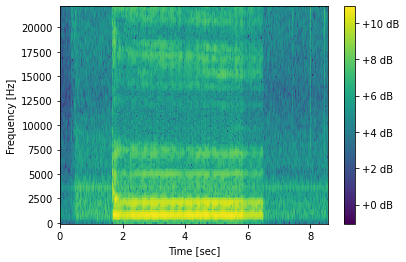

In [76]:
################# GIVEN CODE BELOW #####################

# Fs, data = read('test_single_tones.wav')
Fs, data = read('test_vector.wav')

numFrames = int(len(data) / FRAME_SIZE)
bmp = np.zeros((numFrames, FRAME_SIZE))

total_t = (1/Fs) * len(data) # total time of file in seconds


for i in range(numFrames):
    frame = data[i * FRAME_SIZE : (i + 1) * FRAME_SIZE]
    curFft = ece420ProcessFrame(frame, Fs)
    bmp[i, :] = curFft

bmp = bmp.T

len_t = bmp.shape[1] # number of column is number of time frames
len_f = bmp.shape[0]//2 # number of rows is number of real frequency bins
t = np.linspace(0, total_t, len_t)
f = np.linspace(0, Fs/2, len_f)

plt.figure()
plt.pcolormesh(t, f, bmp[:len_f,:]) #, vmin=0, vmax=1)
plt.axis('tight')
plt.xlabel("Time [sec]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(format="%+2.f dB")
plt.show()

#### Why would you use a STFT over a single-snapshot FFT?

The stft creates spectograms for content whose frequencies vary throughout time (music being a perfect example). For a sound file, the FFT can mark all the frequencies, and at a good amount of frequency resolution since the sound file may be large, but the stft will give some time precision indicating at which time periods some frequency content appears. The standard FFT has no time precision. 

#### What allows us to ignore the second half of our FFT output? Recall the Conjugate Symmetry property of the Fourier Transform?

We can ignore the second half of our FFT because for real valued signals because of the Conjugate Symmetry property. This property results in the second half of the FFT results being symmetric and equal in magnitude as the first half of the results. This makes sense since when we have a sampling rate of Fs, by Nyquist, we are looking for frequencies from 0 to Fs/2.  We cannot look for frequencies from -Fs/2 to 0 since we are dealing with real valued signals. If we were instead taking IQ samples, this would no longer be the case because we would then have complex samples that can no longer be symmetric. That would be the scenario when working with Software Defined Radios and radio frequencies, not audio processing. 

#### Given a buffer size N and a sampling rate Fs, how much time do you have to complete your processing before the next buffer comes in?

You have $\frac{N}{Fs}$ seconds to complete your process. 